Imports and loading files

In [5]:
# Code to read csv file into Colaboratory:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# DRAWING LIBS
import matplotlib.pyplot as plt

# CALCUL LIBS
from math import sqrt, inf

# OTHER LIBS
import random
import time

# Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# link25 = "https://drive.google.com/open?id=1EdqUYzRIGfK2MR1mRVaYJkE58GMrk358"
# link121 = "https://drive.google.com/open?id=1OPZivqLk8RURMYSjS9n7WhgihSO3Nt14"
# link250 = "https://drive.google.com/open?id=1sINK7EL0VpN5N5VQHn-qMqh-SgVccuJT"

# LOAD FILES
csvTSP25 = "../data/TSP25.csv"
csvTSP121 = "../data/TSP121.csv"
csvTSP250 = "../data/TSP250.csv"

# fluff, id = link25.split("=")
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile(csvTSP25) 

# fluff, id = link121.split("=")
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile(csvTSP121) 

# fluff, id = link250.split("=")
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile(csvTSP250) 
# ADD LINES IF USE ANOTHER FILE


Main definition of classes

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Feb 20 20
@author manuvaiRehua
"""

import sys
import signal

FILE = csvTSP250
NB_POPULATION = 200
NB_ITERATION = 1000
MAX_ITERATION = NB_ITERATION
DIFF_MAX = 4
FULL_DEBUG = True and False
RUNNING = True 

def getFormatedTime(t):
  d = int(t / (3600 * 24))
  res = t % (3600 * 24)
  h = int(res / 3600)
  res = res % 3600
  m = int (res / 60)
  res = res % 60

  response = ""
  if d:
    response += "{} d".format(d)
  if h:
    if response != "":
      response += ", "
    response += "{} h".format(h)
  if m:
    if response != "":
      response += ", "
    response += "{} m".format(m)
  if res:
    if response != "":
      response += ", "
    response += "{:.2f} s".format(res)

  return response

def stopRun(signal, frame):
  """
  Signal handler to stop infinite loop.
  @param    signal    The signal caucht.
  @param    frame     The frame.
  """
  global RUNNING
  RUNNING = False
  # exit(0)

class Ville:
  """
  Ville class.
  """
  def __init__(self, nom, tabCords):
    self.nom = nom
    self.x = float(tabCords[0])
    self.y = float(tabCords[1])

  def __str__(self):
    res = "City {} => x={}, y={}".format(self.nom, self.x, self.y)
    return res

  def distanceBetween(villeA, villeB):
    x1, x2 = villeA.x, villeB.x
    y1, y2 = villeA.y, villeB.y

    res = sqrt(((float(x1) - float(x2)) ** 2) + ((float(y1) - float(y2)) ** 2))

    return res

class TSP:
  def __init__(self, file = FILE):
    self.listVilles = self.getVilles(file)
    self.distanceMatrix = self.initDistances()
  
  def getVilles(self, file):
    tab_lines = self.readLines(file)
    tab_villes = [Ville(i, tab_lines[i]) for i in range(len(tab_lines))]

    return tab_villes

  def readLines(self, file):
    def __getNbLines(file):
      res = 0
      with open(file) as f:
        for line in f:
          res += 1
        
      return res

    def __readLines(file):
      res = [(None, None) for i in range(__getNbLines(file))]
      i = 0
      with open(file) as f:
        for line in f:
          res[i] = line.split()
          res[i][0] = float(res[i][0])
          res[i][1] = float(res[i][1])
          i += 1

      return res


    return __readLines(file)

  def initDistances(self):
    matrix = {}

    for villeA in self.listVilles:
      tempMatrix = {}
      for villeB in self.listVilles:
        tempMatrix[villeB.nom] = Ville.distanceBetween(villeA, villeB)

      matrix[villeA.nom] = tempMatrix

    return matrix

  def totalDistance(self, agent):
    tab = agent.path
    res = self.distanceMatrix[tab[0]][tab[-1]]
    for i in range(1, len(tab)):
      res += self.distanceMatrix[tab[i - 1]][tab[i]]

    return res


class Agent:
  def __init__(self, path):
    self.path = path

  def __getitem__(self, index):
    return path[index]

  def __setitem__(self, index, value):
    self.path[index] = value

  def swap(self, i1, i2):
    temp = self.path[i1]
    self.path[i1] = self.path[i2]
    self.path[i2] = temp

  def generateAgent(tab_villes, tsp):
    def __randomGenerate(listVilles):
      path = [v.nom for v in listVilles]
      random.shuffle(path)
      ag = Agent(path)
      return ag

    def __ledGenerate(listVilles, tsp):
      tempTab = [v.nom for v in listVilles]
      response = [tempTab.pop(0)]
      # tsp = self.tsp

      k = len(tempTab)

      for i in range(1, len(listVilles)):
        i1 = random.randint(0, len(tempTab) - 1)
        i2 = random.randint(0, len(tempTab) - 1)

        ville1 = tempTab[i1]
        ville2 = tempTab[i2]

        dist1 = tsp.distanceMatrix[response[i - 1]][ville1]
        dist2 = tsp.distanceMatrix[response[i - 1]][ville2]

        if dist1 < dist2:
          index = i1
        else:
          index = i2

        response.append(tempTab.pop(index))

      return Agent(response)
    
    # ag = __randomGenerate(tab_villes)
    ag = __ledGenerate(tab_villes, tsp)

    return ag
  
class PopulationDrawer:
  def __init__(self, population):
    self.population = population

  
  def drawGraph(self):
    x, y = [], []
    for ville in self.population.tsp.listVilles:
      x.append(ville.x)
      y.append(ville.y)

    plt.plot(x, y, "o")
    plt.title("Villes")

    x, y = [], []
    for i in self.population.getBestAgent().path:
      x.append(self.population.tsp.listVilles[i].x)
      y.append(self.population.tsp.listVilles[i].y)

    plt.scatter(x, y, c="red")

    x.append(self.population.tsp.listVilles[self.population.getBestAgent().path[0]].x)
    y.append(self.population.tsp.listVilles[self.population.getBestAgent().path[0]].y)

    plt.plot(x, y)
    plt.show()

    pass

class Population:
  p_aMuter = 0.1
  p_aMuterInitiale = p_aMuter
  p_mutation = 0.3
  p_selection = 0.5
  p_typeSelection = 0.4

  def __init__(self, tsp, nb = NB_POPULATION):
    self.tsp = tsp
    self.nbAgent = nb
    self.agents = self.initAgents(tsp.listVilles)
    
  def drawGraph(self):
    drawer = PopulationDrawer(self)
    drawer.drawGraph()
    
  def initAgents(self, villes):
    agents = []  
    for i in range(self.nbAgent):
      agents.append(Agent.generateAgent(villes, self.tsp))

    return agents

  def getBestAgent(self):

    best = sorted(self.agents, key = lambda ag: self.tsp.totalDistance(ag))[0]
    return best

  def evolvePopulation(self, nb = NB_ITERATION, timeInSeconds = 0, timeInMinutes = 0):

    # TODO Implements the code to cross on one point instead of 2 points.
    def __crossPathOnePoint(path1, path2):
      index = random.randint(1, len(path1) - 1)

      childPath1, childPath2 = [], []

      for i in range(len(path1)):
        childPath1.append(path1[i])
        childPath2.append(path2[i])

      for i in range(len(path1)):
        if not (path1[i] in childPath2):
          childPath2.append(path1[i])

        if not (path2[i] in childPath1):
          childPath2.append(path2[i])

      return childPath1, childPath2

    def __crossPathTwoPoints(path1, path2):
      pathLen = len(path1)

      index1 = random.randint(1, len(path1) - 1)
      index2 = random.randint(1, len(path1) - 1)
      
      childPath1, childPath2 = [], []

      for i in range(pathLen):
        childPath1.append(None)
        childPath2.append(None)
        
      for i in range(pathLen):
        crossingInTakingOut = index1 > index2 and (i > index1 or i < index2)
        crossingOutTakingIn = index1 < index2 and i > index1 and i < index2

        if (crossingInTakingOut or crossingOutTakingIn):
          childPath1[i] = path1[i]          
          childPath2[i] = path2[i]
      
      for i in range(pathLen):
        if not (path2[i] in childPath1):
          for j in range(pathLen):
            if childPath1[j] is None:
              childPath1[j] = path2[i]
              break

        if not (path1[i] in childPath2):
          for j in range(pathLen):
            if childPath2[j] is None:
              childPath2[j] = path1[i]
              break

      return childPath1, childPath2

    def __generateChilds(agents, tsp = self.tsp):
      iParent1 = random.randint(1, len(agents) - 1)
      iParent2 = random.randint(1, len(agents) - 1)
      
      if random.random() < 0.5:
        pathChild1, pathChild2 = __crossPathTwoPoints(agents[iParent1].path, agents[iParent2].path)
      else:
        pathChild1, pathChild2 = __crossPathOnePoint(agents[iParent1].path, agents[iParent2].path)

      child1 = Agent.generateAgent(tsp.listVilles, tsp)
      child1.path = pathChild1

      child2 = Agent.generateAgent(tsp.listVilles, tsp)
      child2.path = pathChild2

      return (child1, child2)

    def __reproductionPopulation(agents, nb, tsp = self.tsp):
      tab_agents = sorted(agents, key = lambda a: tsp.totalDistance(a))

      tempAgents = []

      for i in range(len(agents), nb, 2):
        ag1, ag2 = __generateChilds(tab_agents)

        tempAgents.append(ag1)
        tempAgents.append(ag2)
      
      if i < nb:
        ag1, temp = __generateChilds(tab_agents)
        tempAgents.append(ag1)
    
      tab_agents += tempAgents

      return tab_agents


    def __mutatePopulation(agents, indexEnd):

      indexStart = (1 - __class__.p_aMuter) * indexEnd
      indexStart = int(indexStart)

      for i in range(indexStart, indexEnd):
        if random.random() < __class__.p_mutation:
          rand1 = random.randint(0, len(agents[0].path) - 1)
          rand2 = rand1 - 1
          agents[i].swap(rand1, rand2)

        if random.random() < __class__.p_mutation:
          rand1 = random.randint(0, len(agents[0].path) - 1)
          rand2 = random.randint(0, len(agents[0].path) - 1)
          agents[i].swap(rand1, rand2)
          
      return agents 
    
    def __computeMutation(currentIndex, lastIndex, lastBest, currentBest):
      if lastBest > currentBest:
        lastBest = currentBest
        lastIndex = currentIndex
        return
      elif lastBest == currentBest:
        lastIndex += 1

      diff = abs(lastIndex - currentIndex)
      if diff > DIFF_MAX:
        __class__.p_aMuter = (1.2) * __class__.p_aMuter
      else:
        __class__.p_aMuter = (0.8) * __class__.p_aMuter
      pass 

    def __evolve(currentIndex, lastIndex, best):
      self.selectionPopulation()
      index = int(self.nbAgent * __class__.p_selection)
      self.agents = __reproductionPopulation(self.agents, self.nbAgent)
      self.agents = __mutatePopulation(self.agents, index)
      __computeMutation(currentIndex, lastIndex, best, self.tsp.totalDistance(self.getBestAgent()))
      if FULL_DEBUG:

        self.drawGraph()

      bestDistance = self.tsp.totalDistance(self.getBestAgent())
      
      print("Best Distance: {}  - {}".format(bestDistance, getFormatedTime(time.time() - startTime)))

    startTime = time.time()
    currentIndex, lastIndex = 0, 0
    best = inf

    timeInSeconds += timeInMinutes * 60
    
    i = 0

    if timeInSeconds != 0:
      while time.time() - startTime < timeInSeconds and RUNNING:
        __evolve(currentIndex, lastIndex, best)
        # print("Iteration {}".format(i))
        i += 1
    else:
      while i < nb and RUNNING:
        __evolve(currentIndex, lastIndex, best)
        i += 1
      
    finishTime = time.time()
    deltaTime = finishTime - startTime

    self.drawGraph()
    print("Code executed in {} seconds".format(deltaTime))
    print("Best Distance: {}  - {}".format(self.tsp.totalDistance(self.getBestAgent()), getFormatedTime(deltaTime)))

  def selectionPopulation(self):
    def __NbyN(agents, nb, tsp = self.tsp):
      tab = sorted(agents, key = lambda ag: tsp.totalDistance(ag))
      indexTronc = int(len(tab) * nb)
      tab = tab[:indexTronc]
      return tab

    def __tournament(ag):
      agents = []
      index = int(len(ag) / 2)
      for i in range(int(len(ag) / 2)):
        chal1 = ag.pop(ag.index(random.choice(ag)))
        chal2 = ag.pop(ag.index(random.choice(ag)))

        if (self.tsp.totalDistance(chal1) > self.tsp.totalDistance(chal2)):
          agents.append(chal2)
        else:
          agents.append(chal1)

      return agents

    p = __class__.p_typeSelection
    
    if random.random() < p:
        self.agents = __NbyN(self.agents, self.__class__.p_selection)
    else:
        self.agents = __tournament(self.agents)


Main program to execute

Best Distance: 93.39950152310588  - 0.08 s
Best Distance: 93.39950152310588  - 0.19 s
Best Distance: 93.39950152310588  - 0.26 s
Best Distance: 93.39950152310588  - 0.34 s
Best Distance: 93.39950152310588  - 0.44 s
Best Distance: 93.21603401489774  - 0.54 s
Best Distance: 93.21603401489774  - 0.62 s
Best Distance: 93.21603401489774  - 0.68 s
Best Distance: 93.21603401489774  - 0.75 s
Best Distance: 93.21603401489774  - 0.86 s
Best Distance: 93.21603401489774  - 0.92 s
Best Distance: 93.13432306913064  - 1.02 s
Best Distance: 93.13432306913064  - 1.09 s
Best Distance: 93.13432306913064  - 1.20 s
Best Distance: 93.13432306913064  - 1.27 s
Best Distance: 93.12083980743714  - 1.39 s
Best Distance: 92.81165796142115  - 1.46 s
Best Distance: 92.81165796142115  - 1.53 s
Best Distance: 92.81165796142115  - 1.63 s
Best Distance: 92.81165796142115  - 1.73 s
Best Distance: 92.81165796142115  - 1.83 s
Best Distance: 92.81165796142115  - 1.94 s
Best Distance: 92.68090204974627  - 2.05 s
Best Distan

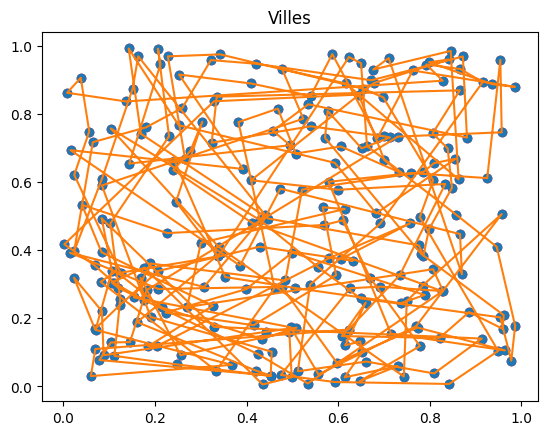

Code executed in 56.76330208778381 seconds
Best Distance: 53.642656344616015  - 56.76 s


In [7]:
def main():
  global RUNNING
  RUNNING = True
  global FILE
  FILE = csvTSP250
  global NB_POPULATION
  NB_POPULATION = 20000
  global NB_ITERATION
  NB_ITERATION = 1000
  global MAX_ITERATION
  MAX_ITERATION = NB_ITERATION
  global DIFF_MAX
  DIFF_MAX = 4
  global FULL_DEBUG
  FULL_DEBUG = True == False

  Population.p_mutation = 0.6
  Population.p_aMuter = 0.1
  Population.p_selection = 0.70
  Population.p_typeSelection = 0.6

  tsp = TSP(FILE)
  signal.signal(signal.SIGINT, stopRun)
  
  population = Population(tsp)
  population.evolvePopulation()


if __name__ == '__main__':
  main()